# How to Digitize Data from Graphs in Published Papers


There are a few methods of digitizing data from published papers; the one I will use for this is called [webplotdigitizer](https://automeris.io/WebPlotDigitizer/) (WPD). This is a web application. There are methods of using the application through linux and R but they are more complicated than is necessary and I found the web application to work perfectly fine.

Click the *Launch Now!* button to start. This will lead you to an example image. The example image can be used to play around and explore the functions of the tool. 


The majority of trait data will be in papers with graphs with an **X** and **Y** axis. Once you have found published papers and downloaded the pdf's, you will need to crop the image you would like to digitize. For example, from _Model on the microbial quality change of seasoned soybean sprouts for on-line shelf life prediction_ by Lee et. al: 

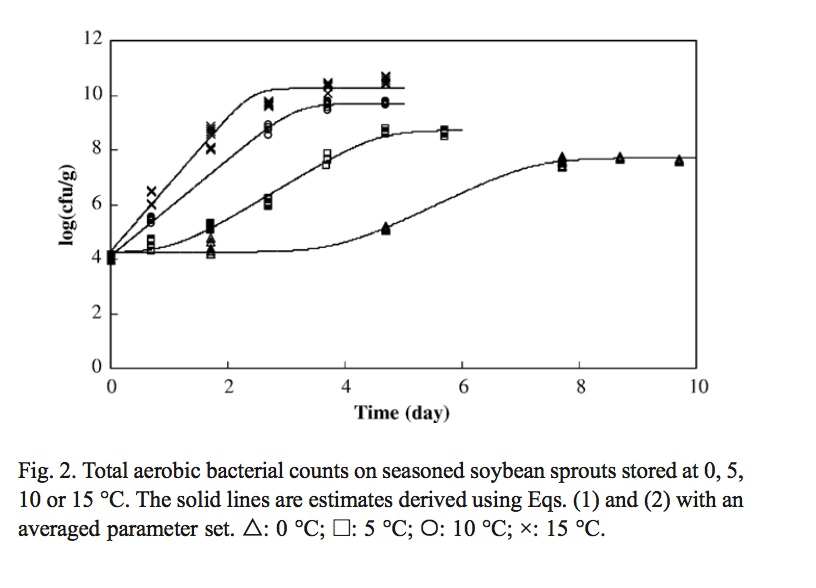

This is a good example of a growth curve chart aligned in **X** and **Y** axis, with time and colony forming units per gram (an abundance measure in microbiology). Please note the units in your digitization. 

You'll need to upload your image to the webplotdigitizer through the file button in the upper left corner: 

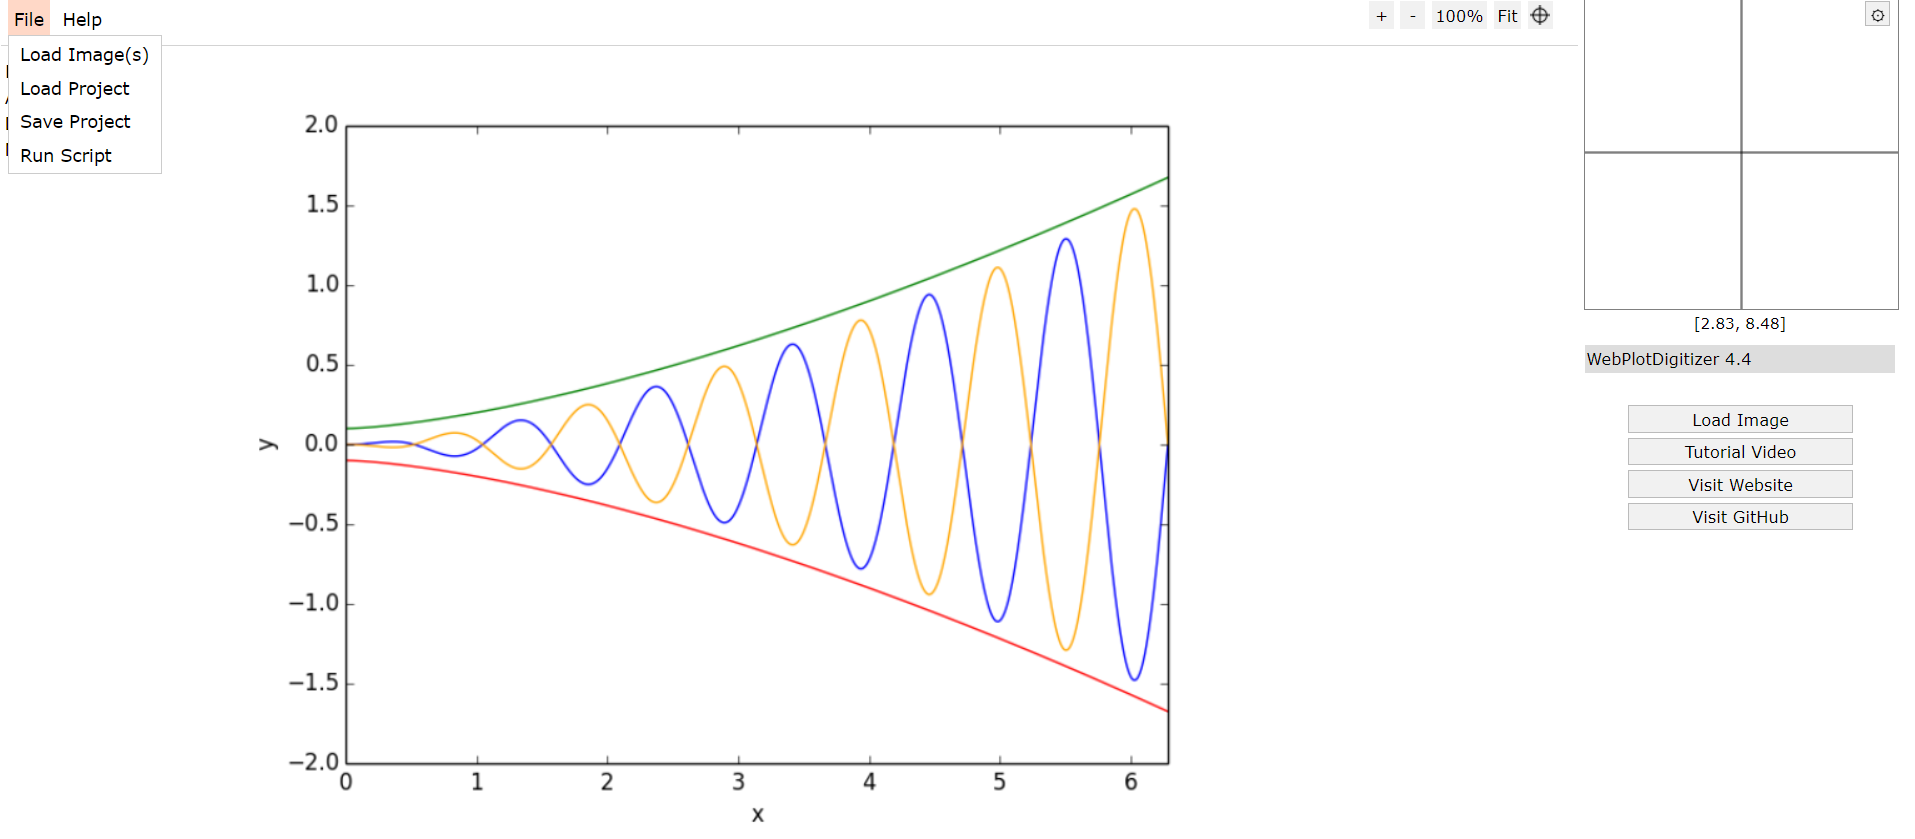

This will be in Load Image(s). Once your image is loaded you'll need to build your axes. Follow the prompts from WPD. Try to get the axes lined up as precisely as possible as this is the basis for the correct digitization of the rest of the graph. There is some alignment correction but you will still need to be as precise as possible, the program can only do so much.

We will start with a manual extraction. This is much more precise and is the far superior option in older or less clear graphs. Pick a single set of data from the image. I will use the 15C set from Lee et al. Rename your dataset to the first set you will be digitizing. Click each of the points. Keep in mind you can use the **S** key in conjuction with the arrow keys to precisely maneuver the point to its location on the graph. When you are done it should look something like this: 

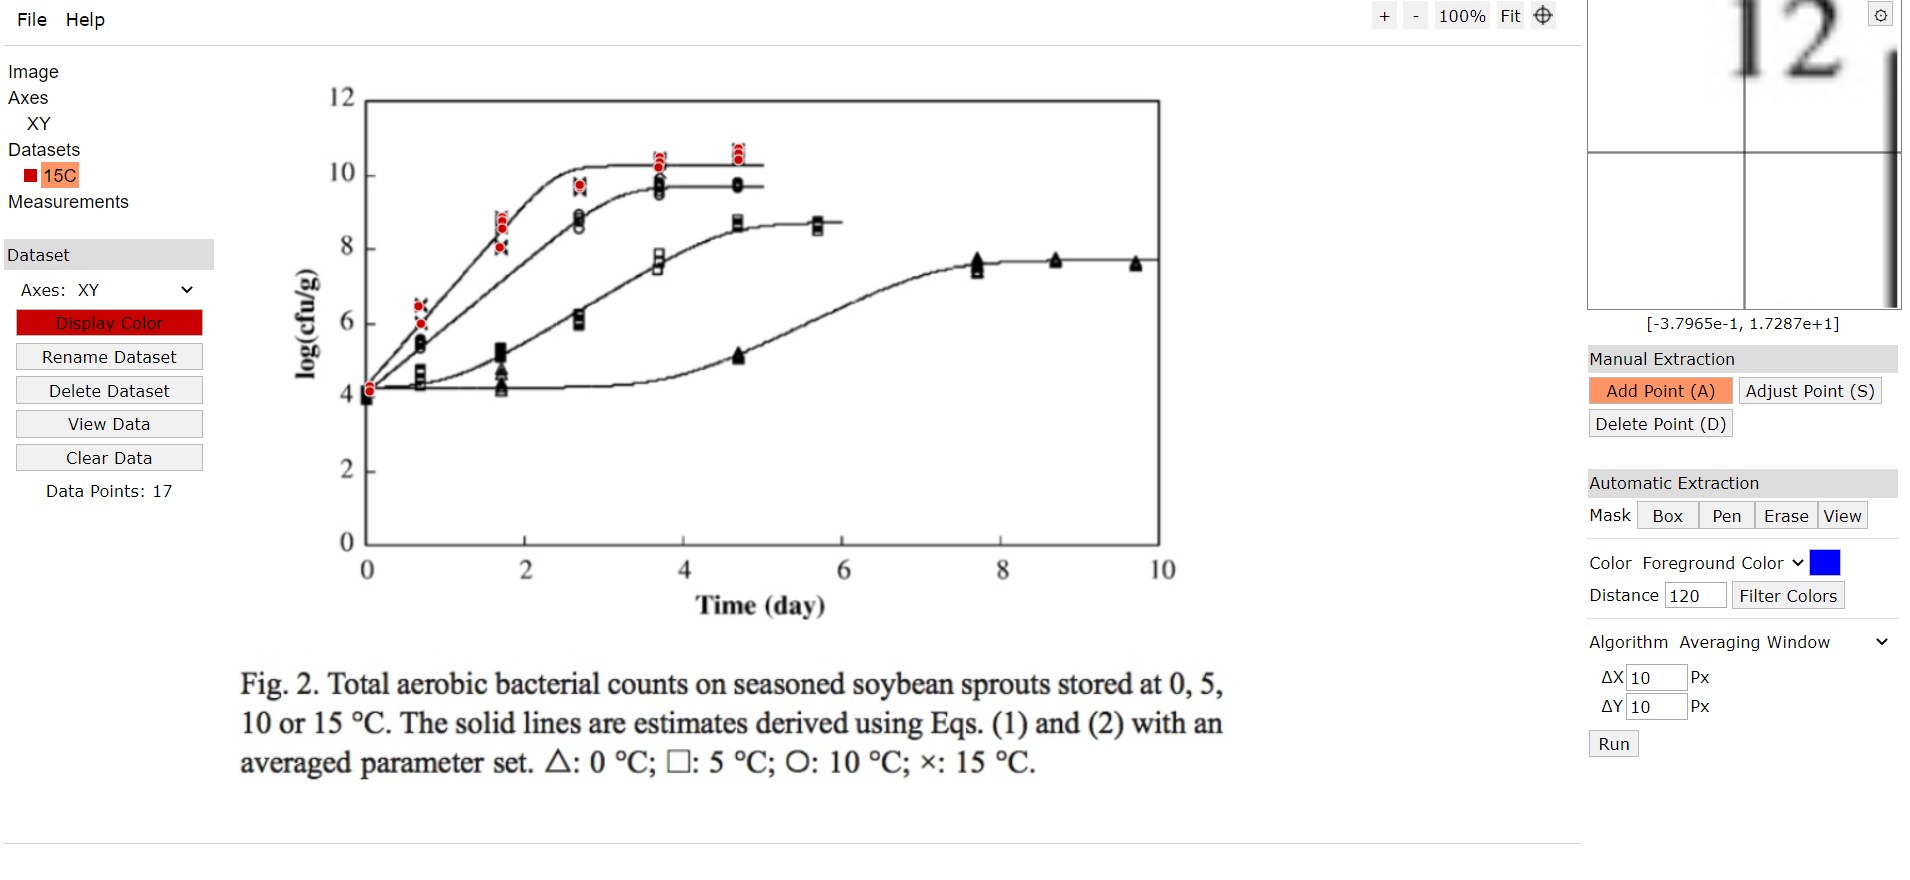

Select the word _Datasets_. Create your new labelled dataset for the next temperature. Repeat the process of selecting each datapoint on the graph. Repeat this process for each of the different tempertures. The final project should look like this:

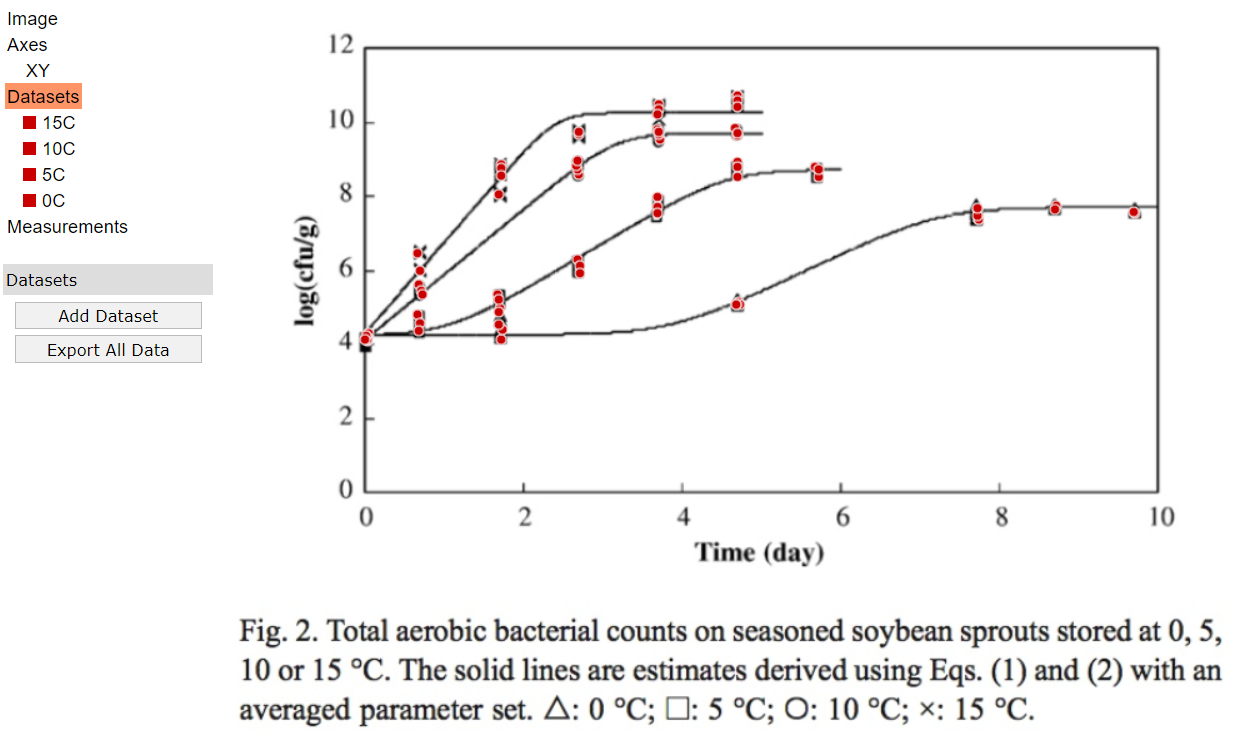

Export all data. This will save the entire project so far as a CSV. Please note your units and any special information necessary to recreate this graph later.

Save the overall file (under file, save project) as a TAR file. Keep this with the file your PDF and csv's are in. This will enable you to fix any problems with relative ease should there inevitably be a mistake in the digitization. 

Depending on your dataset, you will need to format the data differently, using a different function. This is a base function for this particular set of data in **R**:

```R
#data function
format_data <- function(df,temp,time_units,popBio_unts,species,medium,rep,header){
  #get number of datasets
  n_data <- ncol(df)/2
  data_list <- list()
  for(i in 1:n_data){
    #construct dataframe
    df_temp <- df[ , ((i*2)-1) : (i*2) ] %>%
      filter(row_number() > 1) %>%
      mutate_all(as.numeric)
    
    df_temp[df_temp == ""] <- NA
    df_temp <- df_temp %>% na.omit()
    
    #get header
    header <- colnames(df_temp[1]) %>% gsub("X","",.)
    #add data 
    colnames(df_temp) <- c("Time","PopBio")
    df_temp$header <- header
    df_temp$Temp <- temp
    df_temp$Time_units <- time_units
    df_temp$PopBio_unts <- popBio_unts
    df_temp$Species <- species
    df_temp$Medium <- medium
    df_temp$Rep <- rep
    
    data_list[[i]] <- df_temp
  }
  return(bind_rows(data_list))
}

```

Feel free to copy this into your **R** script. Please keep in mind this will need to be edited to your specifications.

You'll need "tidyverse" and "ggplot2" packages. 

From here you'll need to load in your CSV add the headers:

```R
Fig_1 <- read.csv("../Data/Lee_et_al_2007/Fig_1.csv",
                  stringsAsFactors = F) %>%
  format_data(.,"","Hours","log(CFU/g)","aerobic bacteria","soybeans",1)
```

You'll need to squish it down:

```R
final_df <- bind_rows(Fig_1) %>%
  mutate(Temp = header)
drops <- c("header")
final_df <- final_df[ , !(names(final_df) %in% drops)]
```

Edit what needs editing to fit into the right dataset. For example Lee et al. used days as a unit of time, where normally growth curves are done with hours or minutes. Lets change this unit to hours:
```R
final_df <- final_df %>%
  mutate(Time = Time * 24,
         Time_units = "Hours")
```

This is the stage you should check over the data and make sure it looks like the original graph before you add it to the larger database. ggplot2 is a good package for this:
```R
final_df %>%
  ggplot(aes(x=Time,y=PopBio, colour = Temp, group = Temp))+
  geom_point()+
  theme_bw()+
  facet_wrap(~Species)
```

It looks good!

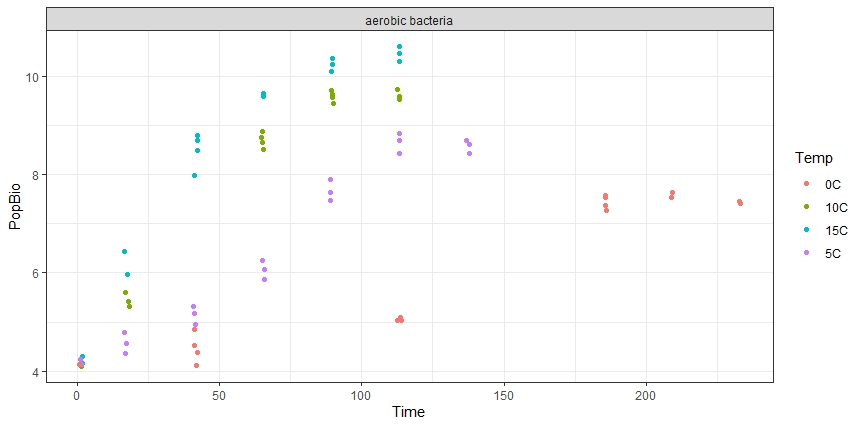

Let's add a citation:
```R
final_df$Citation <- 'Lee, D. S., Hwang, K. J., An, D. S., Park, J. P., & Lee, H. J. (2007). Model on the microbial quality change of seasoned soybean sprouts for on-line shelf life prediction. International Journal of Food Microbiology, 118(3), 285â293. https://doi.org/10.1016/j.ijfoodmicro.2007.07.052'
```

Save the new CSV:
```R
write.csv(final_df,"../Results/Formated/Lee_processed.csv")
```

Repeat this process for each image in each paper which you want to digitize traits from. Save each as a CSV as was done at the end here. From this stage it is a simple matter to `rbind()` the CSV's together as dataframes to create one master CSV with all the data you have digitized. 

If you take away nothing else from this, remember your _**units**_ and check yourself often!

## Uploading to VectorBiTE
Please follow instructions on the [website](https://www.vectorbyte.org/) for how to upload to the global database.